Copyright **`(c)`** 2024 Giovanni Squillero `<giovanni.squillero@polito.it>`  
[`https://github.com/squillero/computational-intelligence`](https://github.com/squillero/computational-intelligence)  
Free for personal or classroom use; see [`LICENSE.md`](https://github.com/squillero/computational-intelligence/blob/master/LICENSE.md) for details.  

# Set Cover problem

See: https://en.wikipedia.org/wiki/Set_cover_problem

In [4]:
from random import random, seed
from itertools import product, accumulate
import numpy as np
from tqdm.auto import tqdm
import matplotlib.pyplot as plt

from icecream import ic

## Reproducible Initialization

If you want to get reproducible results, use `rng` (and restart the kernel); for non-reproducible ones, use `np.random`.

In [4]:
UNIVERSE_SIZE = 1000
NUM_SETS = 100
DENSITY = 0.2

rng = np.random.Generator(np.random.PCG64([UNIVERSE_SIZE, NUM_SETS, int(10_000 * DENSITY)]))

In [101]:
# DON'T EDIT THESE LINES!

SETS = np.random.random((NUM_SETS, UNIVERSE_SIZE)) < DENSITY
for s in range(UNIVERSE_SIZE):
    if not np.any(SETS[:, s]):
        SETS[np.random.randint(NUM_SETS), s] = True
COSTS = np.pow(SETS.sum(axis=1), 1.1)

## Instances generation

### Data

In [102]:
universe_sizes = [100, 1000, 10_000, 100_000, 100_000, 100_000]
num_sets_sizes = [10, 100, 1000, 10_000, 10_000, 10_000]
densities = [.2, .2, .2, .1, .2, .3]

INIT_SOL_TH = 1

## Helper Functions

In [104]:
def valid(sets, solution):
    """Checks wether solution is valid (ie. covers all universe)"""
    phenotype = np.logical_or.reduce(sets[solution])     # at least each element covered by a set
    return np.all(phenotype)                             # all elements are covered

def coverage(sets, solution):
    """Returns the number of covered elements in the universe"""
    phenotype = np.logical_or.reduce(sets[solution])    # at least each element covered by a set
    return np.sum(phenotype)                            # number of covered elements    

def cost(costs, solution):
    """Returns the cost of a solution (to be minimized)"""
    return costs[solution].sum()

def fitness(sets: np.ndarray, costs: np.ndarray, solution: np.ndarray):
    """Returns the fitness of the given solution"""
    return (coverage(sets, solution), -cost(costs, solution))

In [105]:
def single_mutation(solution: np.ndarray):
    pos = rng.integers(0, solution.shape[0])
    solution[pos] = not solution[pos]
    return solution

def multiple_mutation(solution: np.ndarray):
    mask = rng.random(solution.shape[0]) < 0.99
    new_solution = np.logical_xor(mask, solution)
    return new_solution

def multiple_mutation_strength(solution: np.ndarray, strength: float = 0.3) -> np.ndarray:
    mask = rng.random(solution.shape[0]) < strength
    if not np.any(mask):
        mask[np.random.randint(solution.shape[0])] = True
        
    new_sol = np.logical_xor(solution, mask)
    
    return new_sol

### RM hill climbing with single mutation

In [106]:
def solve_single_mutation_HC(sets, costs, num_sets, num_steps=10_000, th=INIT_SOL_TH):
    
    history = []
    solution = rng.random(num_sets) < INIT_SOL_TH
    sol_fitness = fitness(sets, costs, solution)

    print(f"Initial fitness: {sol_fitness}")

    history.append(float(sol_fitness[1]))
    for _ in tqdm(range(num_steps)):
        current = single_mutation(solution.copy())
        curr_fitness = fitness(sets, costs, current)
        
        #print(curr_fitness, sol_fitness)
        
        history.append(float(curr_fitness[1]))
        if curr_fitness > sol_fitness:
            solution = current
            sol_fitness = curr_fitness

    print(f"Final fitness: {sol_fitness}")
    print(f"Last update at iteration {history.index(float(sol_fitness[1]))}")

    plt.figure(figsize=(14, 8))
    plt.plot(
        range(len(history)),
        list(accumulate(history, max)),
        color="red",
    )
    _ = plt.scatter(range(len(history)), history, marker=".")
    
    return sol_fitness

### RM hill climbing with multiple mutation

In [107]:
def solve_multiple_mutation_HC(sets, costs, num_sets, num_steps=10_000, th=INIT_SOL_TH):
    history = []
    solution = rng.random(num_sets) < th
    sol_fitness = fitness(sets, costs, solution)

    print(f"Initial fitness: {sol_fitness}")

    history.append(sol_fitness[1])
    for _ in tqdm(range(num_steps)):
        current = single_mutation(solution.copy())
        curr_fitness = fitness(sets, costs, current)
        
        #print(curr_fitness, sol_fitness)
        
        history.append(curr_fitness[1])
        if curr_fitness > sol_fitness:
            solution = current
            sol_fitness = curr_fitness

    print(f"Final fitness: {sol_fitness}")
    print(f"Last update at iteration {history.index(float(sol_fitness[1]))}")

    plt.figure(figsize=(14, 8))
    plt.plot(
        range(len(history)),
        list(accumulate(history, max)),
        color="red",
    )
    plt.scatter(range(len(history)), history, marker=".")
    
    return sol_fitness

### Simulated annealing
It seems to perform worst than a RMHC: too much going around and not exploit neighboring solutions.

In [108]:
def solve_simulated_annealing_HC(sets, costs, num_sets, num_steps=10_000, th=INIT_SOL_TH):
    
    def complete(covered):
        return covered == sets.shape[1]
    
    history = []
    solution = rng.random(num_sets) < th
    sol_fitness = fitness(sets, costs, solution)
    final_sol_fitness = sol_fitness

    print(f"Initial fitness: {sol_fitness}")

    history.append(sol_fitness[1])
    for i in tqdm(range(num_steps)):
        current = multiple_mutation(solution.copy())      # using single mutation to avoid too much exploration
        curr_fitness = fitness(sets, costs, current)
        
        # Exploring when high coverage, exploiting otherwise
        # Min temperature set to 1 to avoid numerical issues in scalar power
        temperature = max(1, 10 * (sol_fitness[0] / sets.shape[1]) + 0.01)
        
        history.append(curr_fitness[1])
        
        logp = (curr_fitness[1] - sol_fitness[1]) / temperature + 1e-6
            
        if curr_fitness < sol_fitness and np.log(rng.random() + 1e-6) < logp or curr_fitness > sol_fitness:
            
            if curr_fitness > final_sol_fitness and complete(curr_fitness[0]):
                final_sol_fitness = curr_fitness
            
            sol_fitness = curr_fitness
            solution = current

    print(f"Final fitness: {final_sol_fitness}")
    print(f"Last update at iteration {history.index(final_sol_fitness[1])}")

    plt.figure(figsize=(14, 8))
    plt.plot(
        range(len(history)),
        list(accumulate(history, max)),
        color="red",
    )
    plt.scatter(range(len(history)), history, marker=".", color="blue")
    
    return final_sol_fitness

### Simulated annealing with linear self-adaption
Simulated annealing approach but with linear self-adaption. The parameter *strength*, that acts as *temperature*, is increased (or decreased) by a 20% factor, depending on the success of at least one trial out of last five ones.

In [109]:
def solve_linear_SAHC(sets, costs, num_sets, num_steps=10_000, buf_size=5):
    history = []
    buffer = []
    solution = np.full(num_sets, True)
    sol_fitness = fitness(sets, costs, solution)

    ic(sol_fitness)
    history.append(float(sol_fitness[1]))

    strength = 0.5

    for steps in tqdm(range(num_steps)):
        
        new_sol = multiple_mutation_strength(solution, strength)
        new_sol_fitness = fitness(sets, costs, new_sol)
        
        history.append(float(new_sol_fitness[1]))
        
        buffer.append(new_sol_fitness > sol_fitness)
        buffer = buffer[-buf_size: ]
        
        if sum(buffer) > 1:
            strength *= 1.2
            
        elif sum(buffer) == 0:
            strength /= 1.2
        
        if new_sol_fitness > sol_fitness:
            solution = new_sol
            sol_fitness = fitness(sets, costs, solution)
            
    ic(sol_fitness)
    ic(history.index(sol_fitness[1]))

    plt.figure(figsize=(14, 8))
    plt.plot(
        range(len(history)),
        list(accumulate(history, max)),
        color="red",
    )
    plt.scatter(range(len(history)), history, marker=".")
    
    return sol_fitness

### Tabu search
It uses a simulated annealing hill climber, but with discarding tweaked solution with a coverage under 80% on the universe. In this way, too much exploration in discouraged.

In [110]:
def solve_tabu_search_SAHC(sets, costs, num_sets, num_steps=10_000, th=INIT_SOL_TH):
    
    def complete(covered):
        return covered == sets.shape[1]
    
    NUM_CANDIDATES = 10
    history = []
    solution = rng.random(num_sets) < th
    sol_fitness = fitness(sets, costs, solution)
    final_sol_fitness = sol_fitness

    print(f"Initial fitness: {sol_fitness}")

    history.append(sol_fitness[1])
    for i in tqdm(range(num_steps)):
        tmp = [single_mutation(solution.copy()) for _ in range(NUM_CANDIDATES)]
        candidates = [sol for sol in tmp if coverage(sets, sol) / sets.shape[1] > 0.8]
        
        for current in candidates:
            curr_fitness = fitness(sets, costs, current)
            
            # Exploring when high coverage, exploiting otherwise
            # Min temperature set to 10 to avoid numerical issues in scalar power
            temperature = max(1, 10 * (sol_fitness[0] / sets.shape[1]) + 0.01)
            
            history.append(curr_fitness[1])
            logp = (curr_fitness[1] - sol_fitness[1]) / temperature + 1e-6
            if curr_fitness < sol_fitness and np.log(rng.random()+1e-6) < logp or curr_fitness > sol_fitness:
                
                if curr_fitness > final_sol_fitness and complete(curr_fitness[0]):
                    final_sol_fitness = curr_fitness
                
                sol_fitness = curr_fitness
                solution = current

    print(f"Final fitness: {final_sol_fitness}")
    print(f"Last update at iteration {history.index(final_sol_fitness[1])}")

    plt.figure(figsize=(14, 8))
    plt.plot(
        range(len(history)),
        list(accumulate(history, max)),
        color="red",
    )
    plt.scatter(range(len(history)), history, marker=".", color="blue")
    
    return final_sol_fitness

## General solver
Script to solve task with multiple strategies and perform comparisons

In [112]:
class Strategies:
    SINGLE_MUTATION_HC = "Single mutation hill climber"
    MULTIPLE_MUTATION_HC = "Multiple mutation hill climber"
    SIMULATED_ANNEALING_EXP = "Simulated annealing hill climber - Exponential adaption"
    SIMULATED_ANNEALING_LINEAR = "Simulated annealing hill climber - Linear adaption"
    TABU_SEARCH = "Tabu search hill climber"
    GREEDY = "Greedy"
    
    def to_list():
        return [
            Strategies.SINGLE_MUTATION_HC,
            Strategies.MULTIPLE_MUTATION_HC,
            Strategies.SIMULATED_ANNEALING_EXP,
            Strategies.SIMULATED_ANNEALING_LINEAR,
            Strategies.TABU_SEARCH, 
            Strategies.GREEDY
        ]

def solve(sets: np.ndarray, costs: np.ndarray, strategy: str):
    n = sets.shape[0]
    u = sets.shape[1]
    steps = int(min(10_000, max(n*u // 50, 100)))
    th_start = 0.95 if n < 1000 else INIT_SOL_TH
    match strategy:
        case Strategies.SINGLE_MUTATION_HC:
            return solve_single_mutation_HC(sets, costs, n, num_steps=steps)
        case Strategies.MULTIPLE_MUTATION_HC:
            return solve_multiple_mutation_HC(sets, costs, n, num_steps=steps)
        case Strategies.SIMULATED_ANNEALING_EXP:
            return solve_simulated_annealing_HC(sets, costs, n, num_steps=10_000)
        case Strategies.SIMULATED_ANNEALING_LINEAR:
            return solve_linear_SAHC(sets, costs, n)
        case Strategies.TABU_SEARCH:
            return solve_tabu_search_SAHC(sets, costs, n, num_steps=2000)
        case Strategies.GREEDY:
            return solve_greedy(sets, costs, n)

In [ ]:
for (i, (universe_size, num_sets, density)) in list(enumerate(zip(universe_sizes, num_sets_sizes, densities)))[:3]:

    print(f"Generating instance {i+1}")

    SETS, COSTS = generate_data(universe_size, num_sets, density)

    print(f"Solving instance {i+1}")
    
    fitnesses = {}
    for strategy_name in Strategies.to_list():
        fitnesses[strategy_name] = solve(SETS, COSTS, strategy_name)
        plt.show()

    for (strategy, fitness_val) in fitnesses.items():
        print(f"{strategy}: {fitness_val}")

## Definitive solution
Speedup is required. Use a state of covered elements (analog of what done in greedy approach) to keep track of current coverage for each element in the universe.
Using:
- multiple mutation tweak
- heuristic to limit research space
- random start ?
- simulated annealing with self-adaptive parameter ?

### Data

In [12]:
universe_sizes = [100, 1000, 10_000, 100_000, 100_000, 100_000]
num_sets_sizes = [10, 100, 1000, 10_000, 10_000, 10_000]
densities = [.2, .2, .2, .1, .2, .3]

#### Generator function

In [13]:
def generate_data(universe_size, num_sets, density):
    SETS = np.random.random((num_sets, universe_size)) < density
    for s in range(universe_size):
        if not np.any(SETS[:, s]):
            SETS[np.random.randint(num_sets), s] = True
    COSTS = np.pow(SETS.sum(axis=1), 1.1)
    
    return SETS, COSTS

### Helper functions

In [144]:
def init_sol(sets: np.ndarray, dimension: int) -> np.ndarray:
    #solution = np.full(dimension, True)
    # solution = np.random.random(dimension) < 0.8
    #zero_pos = np.argmax(sets.sum(axis=1))
    #zero_pos = rng.integers(0, dimension)
    #solution[zero_pos] = False
    
    less_covered_elem = np.argmin(sets.sum(axis=0))
    solution = np.logical_not(sets[:, less_covered_elem])
    
    return solution

def valid(sets, solution):
    """Checks wether solution is valid (ie. covers all universe)"""
    phenotype = np.logical_or.reduce(sets[solution])     # at least each element covered by a set
    return np.all(phenotype)                             # all elements are covered

def coverage(sets, solution):
    """Returns the number of covered elements in the universe"""
    phenotype = np.logical_or.reduce(sets[solution])    # at least each element covered by a set
    return np.sum(phenotype)                            # number of covered elements    

def cost(costs, solution):
    """Returns the cost of a solution (to be minimized)"""
    return costs[solution].sum()

def fitness(covering: np.ndarray, costs: np.ndarray, solution: np.ndarray):
    """Returns the fitness of the given solution"""
    return (np.sum(covering > 0), -cost(costs, solution))

# Based on Vincenzo Avantaggiato's version
def tweak(solution: np.ndarray, covering: np.ndarray, sets: np.ndarray) -> np.ndarray:
    """Uses a single mutation method"""
    
    new_sol = solution.copy()
    
    index = np.random.randint(0, solution.shape[0])    
    new_sol[index] = not new_sol[index]
    
    modification = 2*new_sol[index]-1
    
    # Rollbacks the modification (if it is a removal): not allowed to remove a set from the solution
    # if its removal causes an element to become uncovered
    if modification == -1 and np.sum(covering[sets[index]] <= 1):
        return solution
        
    # Store the number of sets covering each element in the universe
    covering += modification * sets[index]
    
    """
    mask = np.random.random(solution.shape[0])
    
    new_sol = np.logical_xor(solution, mask)
    
    # Get value of previous solutions whose value changed from 1 to 0
    removed = np.logical_and(solution, mask)
    
    # Get value of previous solutions whose value changed from 0 to 1
    added = np.logical_and(np.logical_not(solution), mask)
    
    removed_mask = np.sum(np.logical_and(sets, removed.reshape(removed.shape[0], 1)), axis=0)
    
    if np.any(np.sum(covering[removed_mask] <= 1, axis=0)):
        return solution
    
    covering += np.sum(np.logical_and(sets, added.reshape(added.shape[0], 1)), axis=0)
    covering -= removed_mask
    """
    return new_sol

In [145]:
def solve_set_cover(sets: np.ndarray, costs: np.ndarray, num_steps: int = 10_000, buf_size: int = 5, init_strength: float = 0.5):
    
    num_sets = sets.shape[0]
    universe_size = sets.shape[1]
    
    solution = init_sol(sets, num_sets)
    best_cov = np.sum(sets[solution], axis=0)
    sol_fitness = fitness(best_cov, costs, solution)
    history = [float(sol_fitness[1])]
    
    for _ in tqdm(range(num_steps)):
        curr_cov = best_cov.copy()
        current = tweak(solution.copy(), curr_cov, sets)
        
        curr_fitness = fitness(curr_cov, costs, current)
        history.append(float(curr_fitness[1]))
        
        #ic(curr_fitness)
        
        if curr_fitness > sol_fitness:
            sol_fitness = curr_fitness
            solution = current
            best_cov = curr_cov
            
    plt.figure(figsize=(14,8))
    plt.plot(
        range(len(history)),
        list(accumulate(history, max)),
        color="red",
    )
    plt.scatter(range(len(history)), history, marker=".", color="blue")
    
    ic(sol_fitness)
    ic(history.index(float(sol_fitness[1])))
    
    #ic(np.sum(sets[solution],axis=1))
    
    return solution, sol_fitness
    

### Greedy approach
For each iteration, we collect the set that covers the larger number of still uncovered elements. The iterations continue until complete universe coverage is reached.

In [146]:
def solve_greedy(sets: np.ndarray, costs: np.ndarray, num_sets) -> np.ndarray:
    
    solution = np.full(num_sets, False)
    set_matrix = sets.copy()
    covered = 0

    while covered < set_matrix.shape[1]:
        
        progress = 100 * covered / set_matrix.shape[1]
        print(float(progress), end=" ")
        
        largest_index = np.argmax(set_matrix.sum(axis=1))
        largest = set_matrix[largest_index, :]
        solution[largest_index] = True
        covered += largest.sum()
        
        # For each row of the matrix, set to False the corresponding column if the cell of the "largest" vector is True
        # Given the vector corresponding to the coverings for the larger set (to collect),
        # it removes all possible coverings for those elements covered by this set,
        # in order to ignore them in next steps
        set_matrix *= np.logical_not(largest)
                
    print()
    
    sol_fitness = fitness(np.sum(sets[solution], axis=0), costs, solution)
    
    return solution, sol_fitness

#### Solver caller
Calls solve function for each required instance. 

ic| f"Generating instance {i+1}": 'Generating instance 1'
ic| f"Solving instance {i+1}": 'Solving instance 1'


  0%|          | 0/1000 [00:00<?, ?it/s]

ic| sol_fitness: (np.int64(100), np.float64(-263.57145602417734))
ic| history.index(float(sol_fitness[1])): 6
ic| sol_state: np.int64(100)
    sol_fitness: np.float64(-263.57145602417734)
ic| greedy_state: np.int64(100)
    greedy_fitness: np.float64(-263.57145602417734)


0.0 30.0 51.0 65.0 75.0 83.0 89.0 94.0 96.0 98.0 


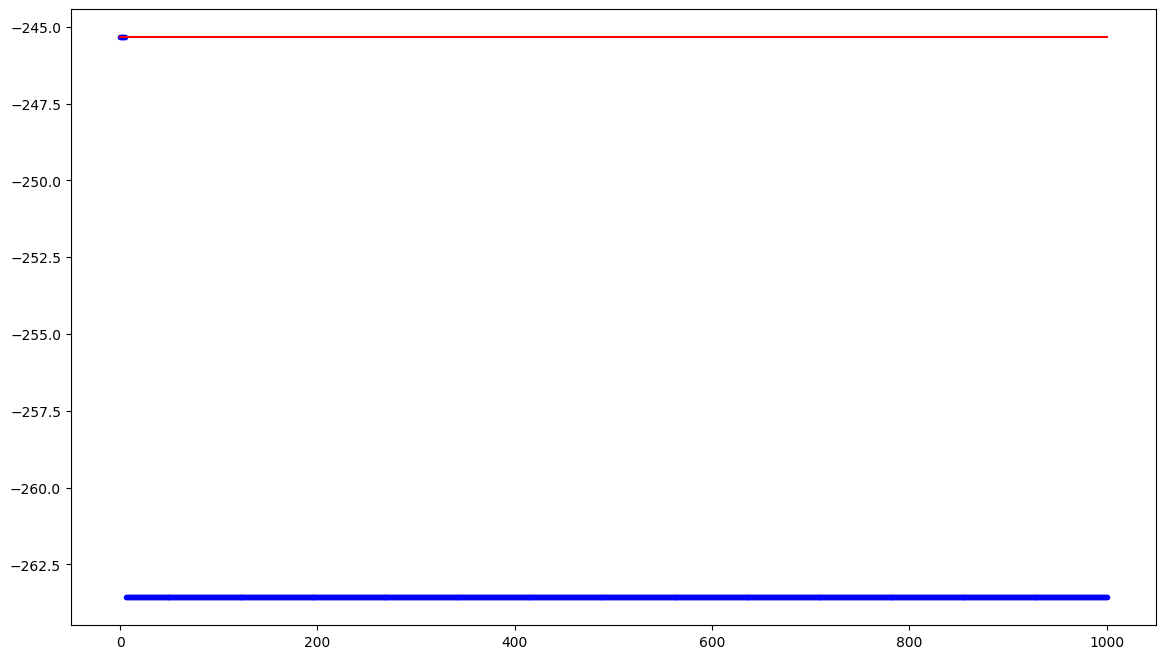

In [147]:
NUM_INSTANCES = len(universe_sizes)

# Useful for debugging
MIN_INSTANCE = 1
MAX_INSTANCE = NUM_INSTANCES

for (i, (universe_size, num_sets, density)) in \
    list(enumerate(zip(universe_sizes, num_sets_sizes, densities))) [MIN_INSTANCE-1 : MAX_INSTANCE]:

    ic(f"Generating instance {i+1}")

    sets, costs = generate_data(universe_size, num_sets, density)
    
    num_steps = 100_000 if i > 2 else (10_000 if i == 2 else 1000)

    ic(f"Solving instance {i+1}")
    
    solution, (sol_state, sol_fitness) = solve_set_cover(sets, costs, num_steps=num_steps)
    greedy_sol, (greedy_state, greedy_fitness) = solve_greedy(sets, costs, num_sets)
    
    ic(sol_state, sol_fitness)
    ic(greedy_state, greedy_fitness)
    